# Perceptron
Implementation of the classic Perceptron by Frank Rosenblatt for binary classification.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## Dataset

In [2]:
data = np.genfromtxt("./data/data.txt", delimiter="\t")
X, y = data[:, :2], data[:, 2]
y = y.astype("int")


print("Class counts:", np.bincount((y)))
print("X shape", X.shape)
print("y shape", y.shape)


# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(1)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]
X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]


# Normalize
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class counts: [50 50]
X shape (100, 2)
y shape (100,)


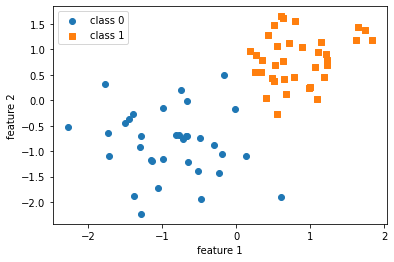

In [3]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

## Model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Perceptron():
    
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        predictions = np.where(linear > 0., 1, 0)
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.size()[0]):
                errors = self.backward(x[i].view(1, self.num_features), y[i]).view(-1)
                self.weights += (errors * x[i]).view(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x)
        accuracy = torch.sum(torch.tensor(predictions).view(-1) == y) / y.shape[0]
        return accuracy

## Train

In [5]:
model = Perceptron(num_features=2)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)


model.train(X_train_tensor, y_train_tensor, epochs=5)


print('Model parameters:')
print('Weights: %s' % model.weights)
print('Bias: %s' % model.bias)

Model parameters:
Weights: tensor([[2.3996],
        [0.8132]])
Bias: tensor([0.])


## Test

In [6]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)


test_acc = model.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 90.00%
